# Práctica del módulo NLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import re
from collections import Counter

from spacy.lang.es.stop_words import STOP_WORDS

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import spacy
import lemminflect
spacy_lemmas = spacy.load('en_core_web_sm')

In [2]:
aiv5 = pd.read_csv("Amazon_Instant_Video_5.csv")
a5 = pd.read_csv("Automotive_5.csv")
dm5 = pd.read_csv("Digital_Music_5.csv")
mi5 = pd.read_csv("Musical_Instruments_5.csv")
plg5 = pd.read_csv("Patio_Lawn_and_Garden_5.csv")

reviews = pd.concat([aiv5,a5,dm5,mi5,plg5], ignore_index=True).dropna(subset=['reviewText','overall']).sample(frac=1)
reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
34176,A34EGGJLO553D8,B0002GYW4C,Christian Matthew,"[1, 1]","Lets be honest, it must be pretty hard to mess...",5,Gets the job done,1313193600,"08 13, 2011"
25773,A3VIOCJZ22JZXT,B00004YMP4,C. B Collins Jr.,"[24, 25]","This CD, anchored by two major hits ""Sandstorm...",4,"Sandstorm, the most catchy electronic tune in ...",1133827200,"12 6, 2005"
34738,A2F2L5F9OWWVY6,B0002E1J5E,AT,"[0, 0]",I'm not a metal player in any means but someti...,5,Great for metal,1364947200,"04 3, 2013"
3412,A3S9HLDFMI6TG1,B0095IDWG2,Yvonne Michel,"[1, 2]",I haven't been disappointed yet with this seri...,5,Each season is filled with wonderous information.,1377216000,"08 23, 2013"
6498,A29IFLFJ61H3W7,B00B8P8O9K,Phil Levin,"[0, 0]",I just learned the series was inspired by the ...,5,Spy vs Spy -,1404691200,"07 7, 2014"


# 2. Análisis de sentimiento

Me traigo mi función de preprocesado de textos y la amplío con nuevas funciones (lemmatizers, ngrams...)

In [3]:
def preprocess_texts(texts, **kwargs):
    
    processed_texts = [] # Aquí me guardaré los textos procesados en forma de lista
    
    # Para el autocorrector que se aplica más abajo utilizaré todo el texto de mi corpus
    if 'auto_correct' in kwargs and kwargs['auto_correct']:
        full_text = " ".join([text for text in texts])
    
    for text in texts:
        
        tokens = [] # Aquí se guardan los tokens que conforman cada texto
        
        # Comenzando con el preprocesado completo de gensim.utils.simple_preprocess()
        if 'simple_gensim' in kwargs and kwargs['simple_gensim']:
            rawtokens = [token for token in gensim.utils.simple_preprocess(text)]
            
        # Si decido aplicar un lemmatizer como split inicial
        elif 'lemmatizer' in kwargs:
            lemmas = kwargs['lemmatizer'](text)
            rawtokens = [token._.lemma() for token in lemmas]
            
        # Hago un split y utilizo tan solo mi preprocesado adicional
        else: rawtokens = text.split()
        
        # Aplico reglas adicionales de preprocesado.
        for token in rawtokens:
            if 'lower' in kwargs and kwargs['lower']: token = token.lower()
            if 'only_alpha' in kwargs and kwargs['only_alpha']: token = re.sub('[^a-zA-Z]+', '', token)
            elif 'regex' in kwargs: token = re.sub(kwargs['regex'], '', token)
            if 'stop_words' in kwargs and token in kwargs.get('stop_words'): token = None

            if token: tokens.append(token)
                
        # Aplico mi corrector ortográfico al texto preprocesado.
        if 'auto_correct' in kwargs and kwargs['auto_correct']:
            for ix in range(len(tokens)):
                tokens[ix] = correct(tokens[ix], full_text, kwargs['auto_correct'])
                
        # Genero N-Gramas
        if 'ngrams' in kwargs:
            
            ngrams = [] # Aquí guardaré los ngramas que reemplazarán a la lista de tokens
            
            # Se puede utilizar una lista de varios ngramas
            if type(kwargs['ngrams']) is list or type(kwargs['ngrams']) is tuple:
                for ngram in kwargs['ngrams']:
                    for i in range(len(tokens)-ngram):
                        ngrams.append(" ".join(tokens[i:i+ngram]))
            
            # También se puede indicar un valor entero como única medida para el ngrama
            else:
                for i in range(len(tokens)-kwargs['ngrams']):
                    ngrams.append(" ".join(tokens[i:i+kwargs['ngrams']]))
                
            tokens = ngrams
        
        processed_texts.append(tokens)
        
    return processed_texts

In [4]:
# Con steps_away indico el número máximo de modificaciones que se realizarán para buscar una corrección.
def correct(word, text, steps_away=1):
    counts = Counter(text)
    
    candidates = [w for w in edits(word, steps=steps_away) if w in text or w is word]
    
    return max(candidates, key=lambda w: counts[w] / len(text))

In [5]:
def edits(word, steps=1):
    
    words = [word]
    
    for step in range(steps):
        
        new_words = []
        
        for word in words:
            letters    = 'abcdefghijklmnopqrstuvwxyz'
            splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
            deletes    = [L + R[1:]                 for L, R in splits if R]
            transposes = [L + R[1] + R[0] + R[2:]   for L, R in splits if len(R)>1]
            replaces   = [L + c + R[1:]             for L, R in splits if R for c in letters]
            inserts    = [L + c + R                 for L, R in splits for c in letters]
            
            new_words += list(set(deletes + transposes + replaces + inserts))

        words += list(set(new_words))
    
    return words

Probaré diferentes modelos con diferentes tipos de preprocesado y al final compararé mis resultados.

Comenzaré construyéndome un corpus que contenga tan solo el texto y una categoría ("muy bueno", "bueno" y "no tan bueno").

In [6]:
reviews = reviews[['reviewText','overall']]
    
reviews.overall = reviews.overall.apply(lambda x: 'very_good' if x == 5 else 'good' if x > 3 else 'not_so_good')

In [7]:
reviews

,reviewText,overall
34176,"Lets be honest, it must be pretty hard to mess...",very_good
25773,"This CD, anchored by two major hits ""Sandstorm...",good
34738,I'm not a metal player in any means but someti...,very_good
3412,I haven't been disappointed yet with this seri...,very_good
6498,I just learned the series was inspired by the ...,very_good
...,...,...
23706,Though it's not as strong as the subsequent tw...,very_good
14937,"Uglier than sin, but it works well. Like the ...",very_good
27330,"The first song on this album is great, but I f...",not_so_good
12045,Tired of being charged WAY to much pretty much...,very_good


In [8]:
reviews.overall.value_counts()

very_good      29874
good           11442
not_so_good     8665
Name: overall, dtype: int64

He decidido realizar esta clasificación debido a que hay demasiadas críticas positivas frente a críticas neutras y negativas. Para saber si dentro de las críticas "no positivas" podemos tener distintos niveles sería conveniente hacer un split y entrenarlas a parte como un conjunto diferente.

Ahora me interesa hacerun split en train y test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    reviews.reviewText,
    reviews.overall,
    train_size=0.80,
    test_size=0.20,
)

Ahora utilizaré el tf-idf de mi corpus de entrenamiento para obtener las palabras más relevantes que detectan el sentimiento y comprobar si tiene sentido, para ello probaré diferentes tipos de preprocesado.

In [10]:
def draw_chi2(Xcorpus, Ycorpus, tfidf):
    # Compute the chi-squared score for each word in the training set and show the values
    i = 15

    chi2score = chi2(Xcorpus, Ycorpus)[0]
    scores = list(zip(tfidf.get_feature_names(), chi2score))
    sorted_scores = sorted(scores, key=lambda x:x[1])
    topchi2 = list(zip(*sorted_scores[-i:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]

    plt.figure(figsize=(12, 8))
    plt.barh(x,topchi2[1], align='center', alpha=0.5)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels, fontsize=12)
    plt.xlabel('$\chi^2$', fontsize=26)
    plt.ylabel('word', fontsize=16)
    plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
    plt.grid()
    plt.tight_layout()
    plt.show();

Con todo pasado a minúsculas, quitando caracteres no alfabéticos y teniendo en cuenta bigramas y trigramas:

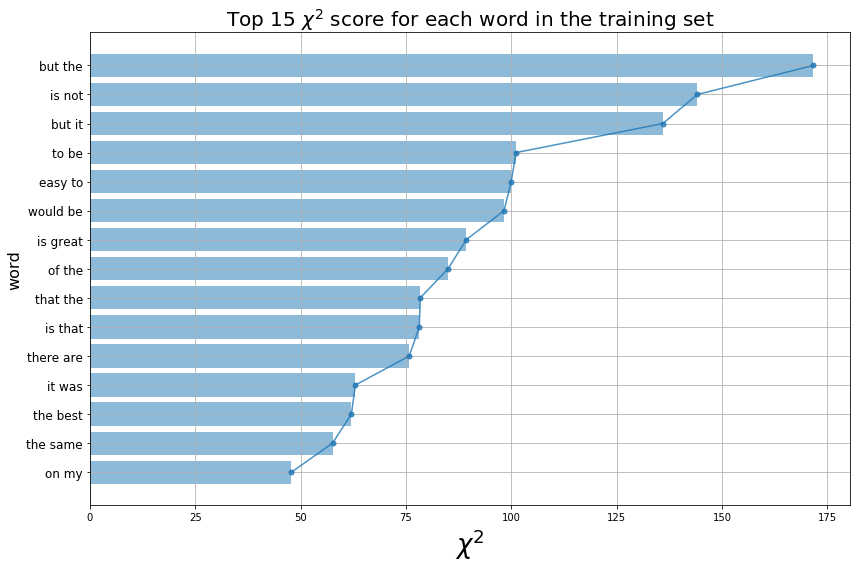

In [11]:
X_train_ = X_train.copy()

for ix, processed_text in zip(X_train.index,
                              preprocess_texts(X_train,
                                               lower=True, only_alpha=True)):
    X_train_[ix] = " ".join(processed_text)
    
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=0.05,
    max_features=2500,
    ngram_range=(2,3)
)
X_train_cv = cv.fit_transform(X_train_)

draw_chi2(X_train_cv, y_train, cv)

No está mal del todo, aunque aparecen muchos verbos auxiliares y determinantes, veamos qué pasa si elimino stop words.

In [12]:
stop_words = set(list(gensim.parsing.preprocessing.STOPWORDS)+list(STOP_WORDS))

Con todo pasado a minúsculas, quitando caracteres no alfabéticos y stop words, y teniendo en cuenta bigramas y trigramas:

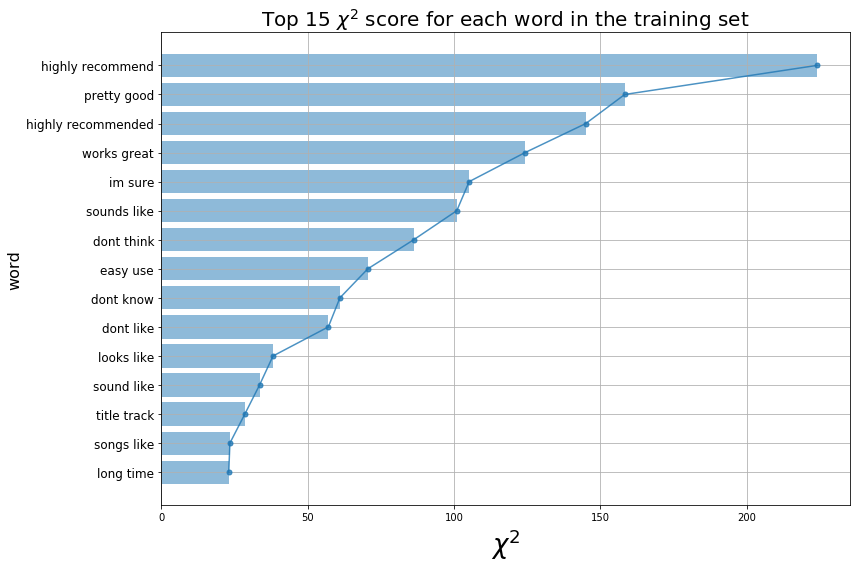

In [13]:
X_train_ = X_train.copy()

for ix, processed_text in zip(X_train.index,
                              preprocess_texts(X_train,
                                               lower=True, only_alpha=True, stop_words=stop_words)):
    X_train_[ix] = " ".join(processed_text)
    
cv = TfidfVectorizer(
    max_df=1.0,
    min_df=0.01,
    max_features=2500,
    ngram_range=(2,3)
)
X_train_cv = cv.fit_transform(X_train_)

draw_chi2(X_train_cv, y_train, cv)

Parece que funciona mejor al identificar bigramas que sí que evidencian una relación con la valoración que se está haciendo, aunque me veo obligado a reducir mucho el juego que pueda tener con min_df y max_df, voy a probar estos mismos parámetros pero utilizando un preprocesado diferente.

Igual que antes pero además lematizando las palabras:

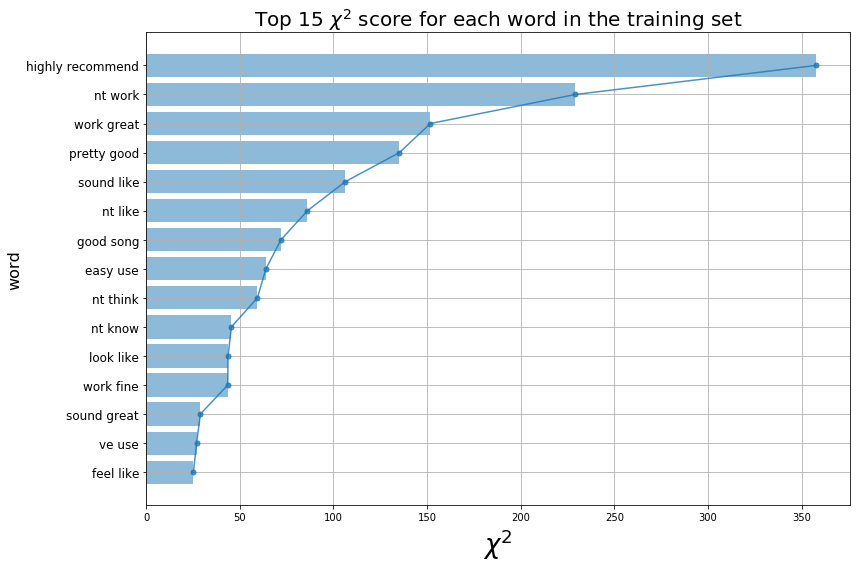

In [14]:
X_train_lemma = X_train.copy()

for ix, processed_text in zip(X_train.index,
                              preprocess_texts(X_train,
                                               lemmatizer=spacy_lemmas,
                                               lower=True, only_alpha=True, stop_words=stop_words)):
    X_train_lemma[ix] = " ".join(processed_text)
    
cv_lemma = TfidfVectorizer(
    max_df=1.0,
    min_df=0.01,
    max_features=2500,
    ngram_range=(2,3)
)
X_train_lemma_cv = cv_lemma.fit_transform(X_train_lemma)

draw_chi2(X_train_lemma_cv, y_train, cv_lemma)

Lo mismo pero sin lematizar y aplicando el preprocesado de gensim:

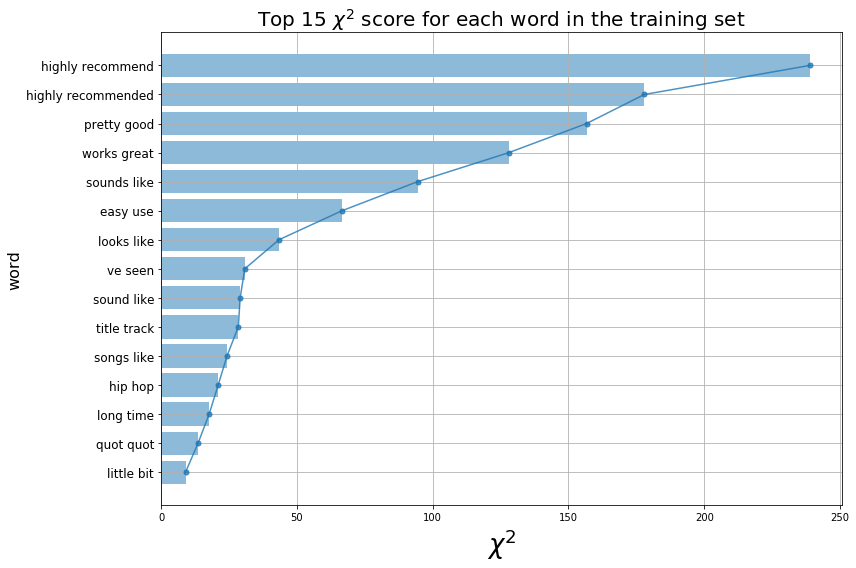

In [15]:
X_train_simple = X_train.copy()

for ix, processed_text in zip(X_train.index,
                              preprocess_texts(X_train,
                                               simple_gensim=True, stop_words=stop_words)):
    X_train_simple[ix] = " ".join(processed_text)
    
cv_simple = TfidfVectorizer(
    max_df=1.0,
    min_df=0.01,
    max_features=2500,
    ngram_range=(2,3)
)
X_train_simple_cv = cv_simple.fit_transform(X_train_simple)

draw_chi2(X_train_simple_cv, y_train, cv_simple)

Diría que mi favorito de todos estos es el que se consigue lematizando las palabras. Que se destaquen tanto palabras como "work", "recommend", "great", "like", "easy" y "good" parece una buena señal. Voy a entrenar un modelo con esos datos y a ver qué tal funciona.

Primero aplico las mismas transformaciones a test para tenerlo preparado cuando llegue el momento de validar el modelo final

In [16]:
X_test_lemma = X_test.copy()

for ix, processed_text in zip(X_test.index,
                              preprocess_texts(X_test,
                                               lemmatizer=spacy_lemmas,
                                               lower=True, only_alpha=True, stop_words=stop_words)):
    X_test_lemma[ix] = " ".join(processed_text)
    
X_test_lemma_cv = cv_lemma.transform(X_test_lemma)

In [17]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_lemma_cv, y_train)
    
    train_predict = lr.predict(X_train_lemma_cv)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_train, train_predict)))

Accuracy for C=0.01: 0.5969887955182073
Accuracy for C=0.05: 0.6005652260904362
Accuracy for C=0.25: 0.6006152460984394
Accuracy for C=0.5: 0.6006152460984394
Accuracy for C=1: 0.600515206082433
Accuracy for C=10: 0.6004401760704282
Accuracy for C=100: 0.6004401760704282
Accuracy for C=1000: 0.6004401760704282
Accuracy for C=10000: 0.6004401760704282


In [18]:
lr = LogisticRegression(C=0.25, max_iter=500)
lr.fit(X_train_lemma_cv, y_train)
    
train_predict = lr.predict(X_train_lemma_cv)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_train, train_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_train, train_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_train, train_predict)))

Confussion matrix:
[[  197   122  8854]
 [  120   211  6610]
 [  131   132 23607]]

Classification report:
              precision    recall  f1-score   support

        good       0.44      0.02      0.04      9173
 not_so_good       0.45      0.03      0.06      6941
   very_good       0.60      0.99      0.75     23870

    accuracy                           0.60     39984
   macro avg       0.50      0.35      0.28     39984
weighted avg       0.54      0.60      0.47     39984

Accuracy score:0.6006152460984394


A ver con un random forest si podemos sacar algo decente

In [ ]:
maxDepth = range(10,20)

gridRFC = GridSearchCV(RandomForestClassifier(n_estimators=200), param_grid={'max_depth': maxDepth}, cv=30)
gridRFC.fit(X_train_lemma_cv, y_train)

print("best mean cross-validation score: {:.3f}".format(gridRFC.best_score_))
print("best parameters: {}".format(gridRFC.best_params_))

scores = np.array(gridRFC.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('30-fold ACC')

plt.show()

In [ ]:
maxDepthOptimo = gridRFC.best_params_['max_depth']

RFC = RandomForestClassifier(max_depth=maxDepthOptimo,n_estimators=200).fit(X_train_lemma_cv, y_train)

train_predict = RFC.predict(X_train_lemma_cv)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_train, train_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_train, train_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_train, train_predict)))

Mejora un poco los resultados pero sigue sin ser gran cosa. ¿Y con word2vec?

In [ ]:
# Imprimir palabras similares

def print_sim_words(word, model):
    query = "Most similar to {}".format(word) 
    print(query)
    print("-"*len(query))
    for sim in model.wv.most_similar(word):
        print("{}:{}{:.3f}{}".format(sim[0], " "*(20-len(sim[0])),
                                     sim[1], " "*10))
    print("\n")

Genero un diccionario y lo entreno con skip gram para conseguir una representación vectorial de cada palabra en base a su contexto

In [ ]:
w2v_sg = Word2Vec(sg=1, size=300, min_count=10, window=10, hs=0, negative=20, workers=4)

train_corpus = preprocess_texts(X_train,
                          lemmatizer=spacy_lemmas,
                          lower=True, regex='[^a-zA-Z!]+', stop_words=stop_words)

w2v_sg.build_vocab(train_corpus)

w2v_sg.train(sentences=train_corpus, total_examples=w2v_sg.corpus_count, epochs=50)

Echo un vistazo para ver si la contextualización tiene sentido

In [ ]:
print_sim_words('recommend', w2v_sg)
print_sim_words('work', w2v_sg)
print_sim_words('great', w2v_sg)
print_sim_words('good', w2v_sg)

Ahora transformo todas las palabras de mi corpus en su vector correspondiente.

In [ ]:
train_vector_corpus = np.zeros((len(train_corpus), 200, 300))

for i1 in range(len(train_corpus)):
    for i2 in range(200):
        try: train_vector_corpus[i1][i2] = w2v_sg.wv[train_corpus[i1][i2]]
        except: pass

In [ ]:
train_vector_corpus.shape

¿Mejorará el resultado?

In [ ]:
maxDepth = range(10,20)

gridRFC = GridSearchCV(RandomForestClassifier(n_estimators=200), param_grid={'max_depth': maxDepth}, cv=30)
gridRFC.fit(train_vector_corpus, y_train)

print("best mean cross-validation score: {:.3f}".format(gridRFC.best_score_))
print("best parameters: {}".format(gridRFC.best_params_))

scores = np.array(gridRFC.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('30-fold ACC')

plt.show()

In [ ]:
maxDepthOptimo = gridRFC.best_params_['max_depth']

RFC = RandomForestClassifier(max_depth=maxDepthOptimo,n_estimators=200).fit(train_vector_corpus, y_train)

train_predict = RFC.predict(train_vector_corpus)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_train, train_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_train, train_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_train, train_predict)))

Veamos qué tal se comporta con los datos de test

In [ ]:
test_corpus = preprocess_texts(X_test,
                               lemmatizer=spacy_lemmas,
                               lower=True, regex='[^a-zA-Z!]+', stop_words=stop_words)

test_vector_corpus = np.zeros((len(train_corpus), 200, 300))

for i1 in range(len(test_corpus)):
    for i2 in range(200):
        try: test_vector_corpus[i1][i2] = w2v_sg.wv[test_corpus[i1][i2]]
        except: pass
    
test_predict = RFC.predict(test_vector_corpus)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_train, train_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_train, train_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_train, train_predict)))